In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf # ==2.10
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Normalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import autokeras as ak
from imblearn.over_sampling import SMOTE
import optuna
from optuna.samplers import TPESampler
from IPython.display import clear_output
# pip freeze > requirements.txt

Pclass — класс пассажира (1 — высший, 2 — средний, 3 — низший);

Name — имя;

Sex — пол;

Age — возраст;

SibSp — количество братьев, сестер, сводных братьев, сводных сестер, супругов на борту титаника;

Parch — количество родителей, детей (в том числе приемных) на борту титаника;

Ticket — номер билета;

Fare — плата за проезд;

Cabin — каюта;

Embarked — порт посадки (C — Шербур; Q — Квинстаун; S — Саутгемптон).

In [2]:
data = pd.read_csv('dataset/titanic/train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data = data[["Pclass", "Sex", 'Survived','SibSp','Parch', 'Age', 'Fare', 'Embarked']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Survived  891 non-null    int64  
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Age       714 non-null    float64
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [5]:
data.dropna(subset=['Embarked'], inplace=True) #Удаляем пустые данные

#### Кодируем методом OHE колонки Embarked и Sex

In [6]:
data = pd.get_dummies(data, columns=['Embarked', 'Sex', 'Pclass'], drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    889 non-null    int64  
 1   SibSp       889 non-null    int64  
 2   Parch       889 non-null    int64  
 3   Age         712 non-null    float64
 4   Fare        889 non-null    float64
 5   Embarked_Q  889 non-null    bool   
 6   Embarked_S  889 non-null    bool   
 7   Sex_male    889 non-null    bool   
 8   Pclass_2    889 non-null    bool   
 9   Pclass_3    889 non-null    bool   
dtypes: bool(5), float64(2), int64(3)
memory usage: 46.0 KB


In [7]:
data.head()

,Survived,SibSp,Parch,Age,Fare,Embarked_Q,Embarked_S,Sex_male,Pclass_2,Pclass_3
0,0,1,0,22.0,7.2500,False,True,True,False,True
1,1,1,0,38.0,71.2833,False,False,False,False,False
2,1,0,0,26.0,7.9250,False,True,False,False,True
3,1,1,0,35.0,53.1000,False,True,False,False,False
4,0,0,0,35.0,8.0500,False,True,True,False,True


##### Заполняем пропуски в колонке Age

In [8]:
print(data['Age'].median())
print(data['Age'].mean())

28.0
29.64209269662921


In [9]:
data.loc[data['Age'].isnull(), 'Age'] = data['Age'].median()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    889 non-null    int64  
 1   SibSp       889 non-null    int64  
 2   Parch       889 non-null    int64  
 3   Age         889 non-null    float64
 4   Fare        889 non-null    float64
 5   Embarked_Q  889 non-null    bool   
 6   Embarked_S  889 non-null    bool   
 7   Sex_male    889 non-null    bool   
 8   Pclass_2    889 non-null    bool   
 9   Pclass_3    889 non-null    bool   
dtypes: bool(5), float64(2), int64(3)
memory usage: 46.0 KB


#### Преобразуем данные в необходимый тип

In [10]:
data['Sex_male'] = data['Sex_male'].astype('int8')
data['Survived'] = data['Survived'].astype('int8')

data['Pclass_2'] = data['Pclass_2'].astype('int8')
data['Pclass_3'] = data['Pclass_3'].astype('int8')
data['SibSp'] = data['SibSp'].astype('int8')
data['Parch'] = data['Parch'].astype('int8')

data['Age'] = data['Age'].astype('int8')

data['Embarked_Q'] = data['Embarked_Q'].astype('int8')
data['Embarked_S'] = data['Embarked_S'].astype('int8')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    889 non-null    int8   
 1   SibSp       889 non-null    int8   
 2   Parch       889 non-null    int8   
 3   Age         889 non-null    int8   
 4   Fare        889 non-null    float64
 5   Embarked_Q  889 non-null    int8   
 6   Embarked_S  889 non-null    int8   
 7   Sex_male    889 non-null    int8   
 8   Pclass_2    889 non-null    int8   
 9   Pclass_3    889 non-null    int8   
dtypes: float64(1), int8(9)
memory usage: 21.7 KB


In [11]:
data['Embarked_S'].value_counts()

Embarked_S
1    644
0    245
Name: count, dtype: int64

#### Строим гистограммы для каждой колонки

array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Fare'}>,
        <Axes: title={'center': 'Embarked_Q'}>],
       [<Axes: title={'center': 'Embarked_S'}>,
        <Axes: title={'center': 'Sex_male'}>,
        <Axes: title={'center': 'Pclass_2'}>],
       [<Axes: title={'center': 'Pclass_3'}>, <Axes: >, <Axes: >]],
      dtype=object)

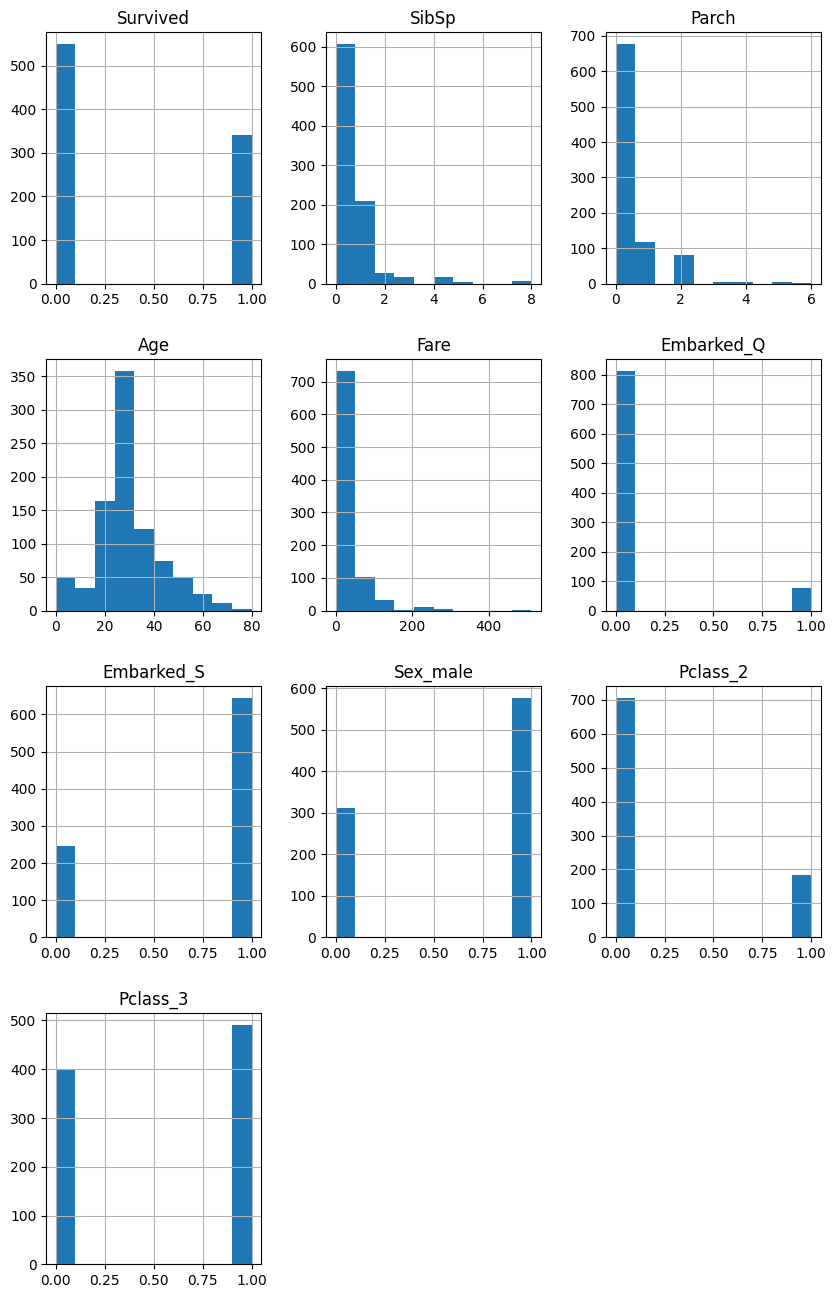

In [12]:
data.hist(figsize=(10,16))

In [13]:
data['Survived'].value_counts() # Дисбаланс классов

Survived
0    549
1    340
Name: count, dtype: int64

In [14]:
features = data.drop(columns=['Survived'])
target = data['Survived']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.15, random_state=12345)

print(features_train.shape)
print(features_test.shape)

(755, 9)
(134, 9)


In [15]:
print(target_train.value_counts())
print(target_test.value_counts())

Survived
0    468
1    287
Name: count, dtype: int64
Survived
0    81
1    53
Name: count, dtype: int64


##### Борьба с дисбалансом классов
Необходимо применить методы борьбы с дисбалансом, чтобы сбалансировать классы

In [16]:
sm = SMOTE(random_state=12345)

features_train_samp, target_train_samp = sm.fit_resample(features_train ,target_train)

target_train_samp.value_counts()

Survived
0    468
1    468
Name: count, dtype: int64

#### Создаём тестовый алгоритм NAS
Подумать над генерацией фитч

<ul>    
    <li>
        <a href ="https://keras.io/api/callbacks/base_callback/">Базовый класс обратного вызова</a>
    </li>
    <li>
        <a href ="https://keras.io/guides/writing_your_own_callbacks/">Написание собственных обратных вызовов</a>
    </li>
    <li>
        <a href ="https://tensorflow.google.cn/guide/keras/custom_callback?hl=ru">Написание собственных обратных вызовов руководство от Tensorflow</a>
    </li>
</ul>

In [17]:
def visuall (history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+ metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+ metric, 'val_'+ metric])
    plt.show()

In [18]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


##### Пробуем искать архитектуру с помощью AutoKeras

In [49]:
'''
data_2 = pd.read_csv("dataset/titanic/train.csv")
features = data_2.drop(columns=['Survived'])
target = data_2['Survived']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.15, random_state=12345)
'''

print(features_train.shape)
print(features_test.shape)

clf = ak.StructuredDataClassifier(overwrite=True, max_trials=20)
clf.fit(features_train_samp, target_train_samp, epochs = 150, validation_data=(features_test, target_test))

Trial 20 Complete [00h 00m 08s]
val_accuracy: 0.8059701323509216

Best val_accuracy So Far: 0.8432835936546326
Total elapsed time: 00h 03m 29s
INFO:tensorflow:Oracle triggered exit


Epoch 1/150
30/30 [==============================] - 1s 10ms/step - loss: 0.6485 - accuracy: 0.6635 - val_loss: 0.5846 - val_accuracy: 0.7612
Epoch 2/150
30/30 [==============================] - 0s 6ms/step - loss: 0.5437 - accuracy: 0.7863 - val_loss: 0.5444 - val_accuracy: 0.7836
Epoch 3/150
30/30 [==============================] - 0s 6ms/step - loss: 0.4806 - accuracy: 0.8323 - val_loss: 0.5234 - val_accuracy: 0.7985
Epoch 4/150
30/30 [==============================] - 0s 6ms/step - loss: 0.4368 - accuracy: 0.8333 - val_loss: 0.5128 - val_accuracy: 0.7985
Epoch 5/150
30/30 [==============================] - 0s 6ms/step - loss: 0.4083 - accuracy: 0.8323 - val_loss: 0.5055 - val_accuracy: 0.7910
Epoch 6/150
30/30 [==============================] - 0s 6ms/step - loss: 0.3916 - accuracy: 0.8323 - val_loss: 0.5025 - val_accuracy: 0.7985
Epoch 7/150
30/30 [==============================] - 0s 6ms/step - loss: 0.3823 - accuracy: 0.8333 - val_loss: 0.5001 - val_accuracy: 0.8060
Epoch 8/150


In [51]:
model = clf.export_model()
model.summary()
print(clf.evaluate(features_test, target_test))

'''
try:
    clf.save("model_autokeras", save_format="tf")
except Exception:
    clf.save("model_autokeras.h5")
'''


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 9)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                320       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

'\ntry:\n    clf.save("model_autokeras", save_format="tf")\nexcept Exception:\n    clf.save("model_autokeras.h5")\n'

##### Заметка
Встроенные средства обработки данных хуже, чем обработка вручную. Модель в конечном итоге построилась более "глубокой", чем с предварительной обработкой


#### Пробуем собственную архитектуру

In [20]:
model = Sequential()
model.add(Dense(features_train.shape[1], input_shape = (features_train.shape[1],), activation = 'relu'))

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(1, activation = 'sigmoid'))
optimizer = Adam(learning_rate = 0.001)


model.compile(loss ='binary_crossentropy', optimizer = optimizer, metrics = ['BinaryAccuracy', 'AUC'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 90        
                                                                 
 dense_1 (Dense)             (None, 32)                320       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

Epoch 1/1000
117/117 - 5s - loss: 0.7790 - binary_accuracy: 0.5491 - auc: 0.5820 - val_loss: 0.6288 - val_binary_accuracy: 0.6940 - val_auc: 0.6827 - 5s/epoch - 39ms/step
Epoch 2/1000
117/117 - 1s - loss: 0.7164 - binary_accuracy: 0.5908 - auc: 0.6287 - val_loss: 0.6458 - val_binary_accuracy: 0.6642 - val_auc: 0.6837 - 660ms/epoch - 6ms/step
Epoch 3/1000
117/117 - 1s - loss: 0.6945 - binary_accuracy: 0.5994 - auc: 0.6354 - val_loss: 0.6433 - val_binary_accuracy: 0.6866 - val_auc: 0.7192 - 728ms/epoch - 6ms/step
Epoch 4/1000
117/117 - 1s - loss: 0.6767 - binary_accuracy: 0.6197 - auc: 0.6517 - val_loss: 0.6305 - val_binary_accuracy: 0.6791 - val_auc: 0.7287 - 709ms/epoch - 6ms/step
Epoch 5/1000
117/117 - 1s - loss: 0.6874 - binary_accuracy: 0.6026 - auc: 0.6364 - val_loss: 0.6234 - val_binary_accuracy: 0.6791 - val_auc: 0.7212 - 621ms/epoch - 5ms/step
Epoch 6/1000
117/117 - 1s - loss: 0.6646 - binary_accuracy: 0.5983 - auc: 0.6539 - val_loss: 0.6465 - val_binary_accuracy: 0.6791 - val_a

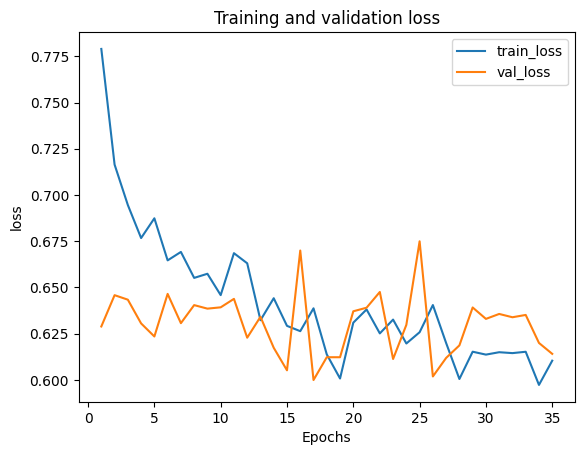

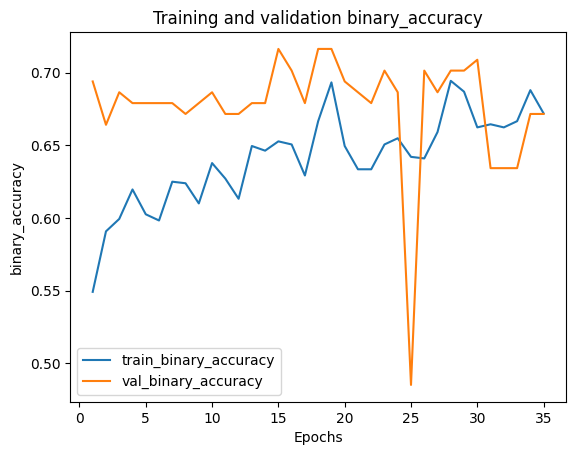

CPU times: total: 3.62 s
Wall time: 26.9 s


In [21]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20, mode='max', min_delta=0.0001, restore_best_weights = True)

history = model.fit(features_train_samp, target_train_samp, verbose = 2, batch_size = 8, epochs = 1000, 
    validation_data=(features_test, target_test), callbacks=[callback])


visuall(history, 'loss')
visuall(history, 'binary_accuracy')

In [43]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [26]:
bin_acc = model.evaluate(features_test, target_test)[1]
bin_acc

5/5 [==============================] - 0s 3ms/step - loss: 0.6051 - binary_accuracy: 0.7164 - auc: 0.7420


0.7164179086685181

## Реализуем алгоритм NAS основанный на TPE 
TPE - Tree-structured Parzen Estimator (оценщик Парзена с древовидной структурой)

In [ ]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

In [31]:


def nas(trail):
    layers = trail.suggest_int('count_layers', 1,4, log = True)
    units = trail.suggest_categorical("units", [32, 64, 128, 256, 512])
    dropouts = trail.suggest_categorical("dropout", [0.1, 0.2, 0.25, 0.3])

    model = Sequential()
    for i in range(layers):
        if i==0:
            model.add(Dense(units, input_shape = (features_train_samp.shape[1],), activation = 'relu'))
            model.add(Dropout(dropouts))
            model.add(Normalization())
        else:
            model.add(Dense(units//(i*2), activation = 'relu'))
            model.add(Dropout(dropouts))
            model.add(Normalization())

    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = Adam(learning_rate = 0.001)

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20, mode='max', min_delta=0.0001, restore_best_weights = True)

    model.compile(loss ='binary_crossentropy', optimizer = optimizer, metrics = ['BinaryAccuracy', 'AUC'])
    model.summary()

    history = model.fit(features_train_samp, target_train_samp, verbose = 2, batch_size = 8, epochs = 1000, 
        validation_data=(features_test, target_test), callbacks=[callback])
    
    bin_acc = model.evaluate(features_test, target_test)[1]
    clear_output(wait=True)
    
    return bin_acc

sampler = TPESampler(seed=12345)
study = optuna.create_study(study_name="ANN", direction="maximize", sampler=sampler)
study.optimize(nas, n_trials=20)




[I 2023-06-06 10:56:47,205] Trial 47 finished with value: 0.8134328126907349 and parameters: {'count_layers': 3, 'units': 256, 'dropout': 0.2}. Best is trial 24 with value: 0.8283582329750061.


Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_200 (Dense)           (None, 512)               5120      
                                                                 
 dropout_143 (Dropout)       (None, 512)               0         
                                                                 
 normalization_139 (Normaliz  (None, 512)              1025      
 ation)                                                          
                                                                 
 dense_201 (Dense)           (None, 256)               131328    
                                                                 
 dropout_144 (Dropout)       (None, 256)               0         
                                                                 
 normalization_140 (Normaliz  (None, 256)              513       
 ation)                                              

[W 2023-06-06 10:56:59,347] Trial 48 failed with parameters: {'count_layers': 4, 'units': 512, 'dropout': 0.3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "d:\Jupiter\AutoML_with_custom_NAS\.venv\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\ykolt\AppData\Local\Temp\ipykernel_23476\2677353517.py", line 25, in nas
    history = model.fit(features_train_samp, target_train_samp, verbose = 2, batch_size = 8, epochs = 1000,
  File "d:\Jupiter\AutoML_with_custom_NAS\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "d:\Jupiter\AutoML_with_custom_NAS\.venv\lib\site-packages\keras\engine\training.py", line 1606, in fit
    val_logs = self.evaluate(
  File "d:\Jupiter\AutoML_with_custom_NAS\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs

KeyboardInterrupt: 

In [35]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"\t{key} : {value}")

Number of finished trials:  49
Best trial:
  Value:  0.8283582329750061
  Params: 
	count_layers : 2
	units : 256
	dropout : 0.2


## Предварительные результаты
1. Техника upsample помогла увеличить точность на валидации
2. Необходимо разработать алгоритм подбора архитектуры. Для начала сделать подбор количества нейронов в полу готовой архитектуре. Результат сравнивать по модели, которую нашёл алгоритм AutoKeras
3. Для поиска архитектуры можно использовать AutoTuner от Keras.  
4. Попробовать алгоритмы shap для поиска необходимых фитч и Optuna для поиска гиперпарраметров.